In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from PIL import Image

# 1. 데이터셋 준비
def load_dataset():
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

In [ ]:
# 2. 모델 초기화 및 구조 수정 (최종 레이어만 fine-tuning)
def initialize_model(num_classes=10):
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)

    # 모든 레이어를 고정하고 최종 레이어만 학습하도록 설정
    for param in model.parameters():
        param.requires_grad = False

    # 마지막 출력 레이어를 CIFAR-10에 맞게 수정하고, BatchNorm 추가
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),      # Batch Normalization 추가
        nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    )

    return model


# 3. 학습 및 평가 함수 정의
def train(model, trainloader, criterion, optimizer, device, clip_value=1.0):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        # Gradient clipping 추가 적용
        nn_utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(trainloader.dataset)
    accuracy = 100 * correct / total
    return train_loss, accuracy

def test(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(testloader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy



In [ ]:
# 4. 모델 학습 및 최적 성능 저장
def train_and_save(model, trainloader, testloader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0001, weight_decay=0.001)  # 최종 레이어만 학습 / 파라미터 추가
    best_acc = 0.0
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_acc = test(model, testloader, criterion, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'fine_tuned_resnet50_cifar10_best_5.pth')
            print("Best model saved with accuracy: {:.2f}%".format(best_acc))


# 5. 모델 로드 및 추론 (시각화 포함)
def load_and_predict_visualize(img_path, model, classes, device):
    # 모델 가중치 불러오기
    model.load_state_dict(torch.load('fine_tuned_resnet50_cifar10_best_5.pth'))
    model.to(device)
    model.eval()


    # 이미지 전처리
    preprocess = ResNet50_Weights.DEFAULT.transforms()
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    # 모델 예측
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    class_name = classes[predicted.item()]

    # 이미지 시각화
    plt.imshow(img)
    plt.title(f'Predicted: {class_name}')
    plt.axis('off')
    plt.show()




Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 0.9583, Train Acc: 68.38%, Test Loss: 0.6790, Test Acc: 77.79%
Best model saved with accuracy: 77.79%
Epoch 2/10, Train Loss: 0.7055, Train Acc: 76.49%, Test Loss: 0.6058, Test Acc: 79.83%
Best model saved with accuracy: 79.83%
Epoch 3/10, Train Loss: 0.6621, Train Acc: 78.16%, Test Loss: 0.5954, Test Acc: 80.54%
Best model saved with accuracy: 80.54%
Epoch 4/10, Train Loss: 0.6420, Train Acc: 78.67%, Test Loss: 0.5762, Test Acc: 80.97%
Best model saved with accuracy: 80.97%
Epoch 5/10, Train Loss: 0.6293, Train Acc: 79.41%, Test Loss: 0.5657, Test Acc: 81.12%
Best model saved with accuracy: 81.12%
Epoch 6/10, Train Loss: 0.6148, Train Acc: 79.58%, Test Loss: 0.5573, Test Acc: 81.57%
Best model saved with accuracy: 81.57%
Epoch 7/10, Train Loss: 0.6137, Train Acc: 79.72%, Test Loss: 0.5594, Test Acc: 81.46%
Epoch 8/10, Train Loss: 0.6069, Train Acc: 79.77%, Test Loss: 0.5489, Test Acc: 8

<ipython-input-7-bac423a7db4d>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tuned_resnet50_cifar10_best_5.pth'))


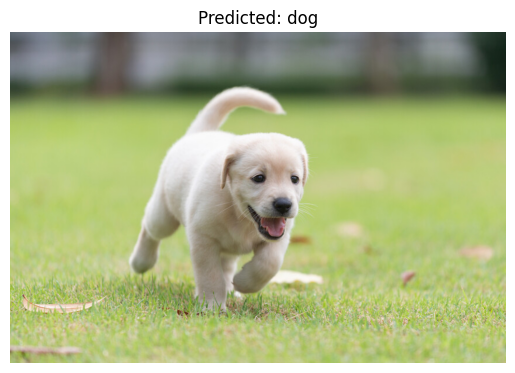

In [ ]:
# Main 코드 실행
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader, testloader, classes = load_dataset()
    model = initialize_model().to(device)


    # 모델 학습 및 최고 성능 epoch과 accuracy 저장
    train_and_save(model, trainloader, testloader, device)

    # 예측할 이미지를 불러와 추론 및 시각화
    img_path = "/content/Dog1.jpg"  # 실제 예측할 이미지 경로로 변경 필요
    load_and_predict_visualize(img_path, model, classes, device)